In [1]:
# Documentation: http://soft-matter.github.io/trackpy/v0.5.0/api.html
# Eric Weeks Tutorial: http://www.physics.emory.edu/faculty/weeks//idl/

In [2]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

In [3]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import pims
import trackpy as tp


# Analysing the Data
**Opening images**
Can open a varietyy of files

In [4]:
@pims.pipeline
def gray(image):
    return image[:, :, 1]  # Take just the green channel

frames = pims.as_grey(pims.open('M1 to cathode.tif.crdownload.tif'))

In [5]:
frames

(TiffStack_tifffile,) processed through proc_func. Original repr:
    <Frames>
    Source: M1 to cathode.tif.crdownload.tif
    Length: 60 frames
    Frame Shape: (2200, 2688)
    Pixel Datatype: uint8

In [6]:
print(frames[0])  # the first frame

[[10 10  9 ... 11 11 11]
 [10 11  9 ... 10 10 10]
 [10  9 10 ... 12 11 10]
 ...
 [14 13 14 ... 16 18 17]
 [14 12 14 ... 16 17 15]
 [13 14 13 ... 17 16 16]]


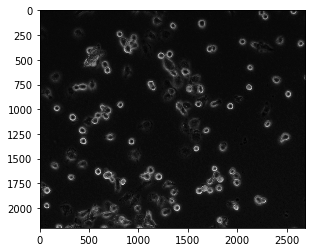

In [7]:
plt.imshow(frames[0])

# Locate Features
**Using the size of the features (in pixels)**

In [14]:
# must be an odd integer (from document we know size = 4.31 pix/um)
# algorithm looks for bright features, if target were dark-> invert=True

f = tp.locate(frames[0], 57, invert=False)
f.head() # shows only the first few rows of the data

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,45.413258,61.957753,2383.678265,18.840269,0.152404,2.142632,25502.0,-0.136488,0
1,50.425446,1488.521092,2374.572079,17.853636,0.013021,2.142632,25437.0,-0.135653,0
2,48.556202,735.891473,1934.796830,17.424120,0.192005,2.142632,25371.0,-0.134815,0
3,56.631725,1737.789118,1742.495595,18.107222,0.201133,2.678290,25645.0,-0.138362,0
4,85.124438,1203.284283,16792.343807,13.982247,0.412638,38.567379,76527.0,0.035607,0


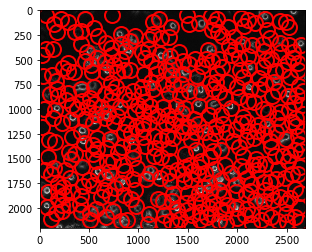

In [15]:
tp.annotate(f,frames[0])

# Redefining parameters to eliminate spurious features
Again, avoiding groups and false positives

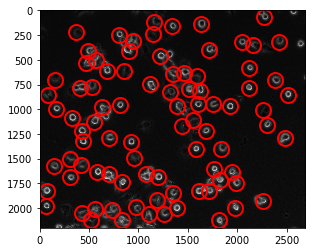

In [17]:
f = tp.locate(frames[0], 101, minmass=20000) # tripple digits apear to work well
# total brightess ("mass")
tp.annotate(f, frames[0])

[Text(0, 0.5, 'count'), Text(0.5, 0, 'Mass')]

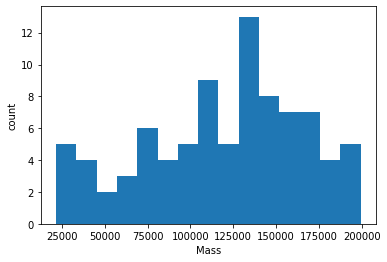

In [18]:
# now dealing with false positives (due to fleeting preaks in brightness)
# we will me looking at the total brightness (mass)
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=15)

ax.set(xlabel='Mass', ylabel = 'count')

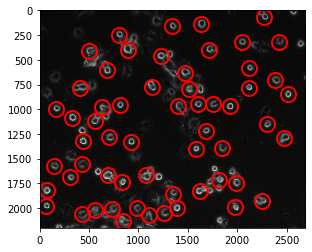

(array([4., 1., 4., 3., 8., 8., 8., 4., 5., 3., 6., 1., 1., 1., 1.]),
 array([109823.19985738, 122342.65962665, 134862.11939592, 147381.57916519,
        159901.03893446, 172420.49870373, 184939.958473  , 197459.41824227,
        209978.87801154, 222498.33778081, 235017.79755009, 247537.25731936,
        260056.71708863, 272576.1768579 , 285095.63662717, 297615.09639644]),
 <a list of 15 Patch objects>)

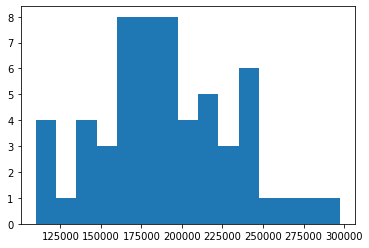

In [27]:
# we can see that there are a lot of variance to the mass of our cells
# I chose 80k as the minimum mass to reduce false positives
f = tp.locate(frames[0], 131, minmass=100000) # tripple digits apear to work well
tp.annotate(f, frames[0])

fig, ax = plt.subplots()
ax.hist(f['mass'], bins=15)

# Checking for subpixel accuracy

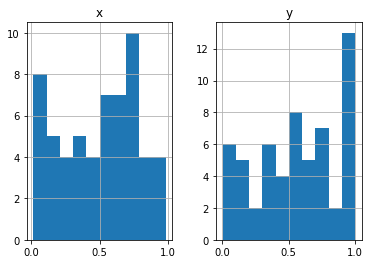

In [28]:
# a quick way to check for subpixel accuracy 
# is to check that the decimal part of 
# the x and/or y positions are evenly distributed
tp.subpx_bias(tp.locate(frames[0], 131, minmass=100000));

# Locating features in all frames

Worth noting that memory issues became apparent with higher pixel counts/mass

In [30]:
# As each frame is analyzed, tp.batch reports the frame number and how many features were found. 
# If this number runs unexpectedly low or high, you may wish to interrupt it and try different 
# parameters.

If your images are small, you may find that printing this number actually slows down batch significantly! In that case you can run tp.quiet() to turn it off.
f = tp.batch(frames[:], 101, minmass=80000)

Frame 59: 59 features


In [32]:
tp.quiet() #Turn off progress reports for best perfomance
f2 = tp.batch(frames[:], 111, minmass=100000)

# Linking features into particle trajectories

In [43]:
# First we must specify a max displacement that a particle can have between frames
# We will start with 50 pixels
# Larger values slow down this process considerably
# Second, we must allow possibility that a particle might be missed for a few frames (add memory)

t1 = tp.link(f, 50, memory=3)
# print(t1.head())

t2 = tp.link(f2, 50, memory=3)
# print(t2.head())

In [46]:
# Filtering spurious trajectories
# These are trajectories that are only seen in a few frames

t11 = tp.filter_stubs(t1,25)
# compare the number of particles int he unfiltered and filtered data
print('Before:', t1['particle'].nunique())
print('After:', t11['particle'].nunique())

t22 = tp.filter_stubs(t2,25)
print('Before:', t2['particle'].nunique())
print('After:', t22['particle'].nunique())

Before: 330
After: 42
Before: 293
After: 39


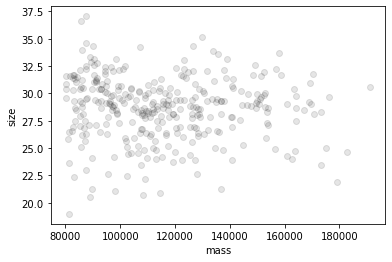

In [50]:
# we can filter trajectories by their particles appearance
# we can look at a feature's "average appearance" through its trajectory, given more accurate picture

plt.figure()
tp.mass_size(t1.groupby('particle').mean())

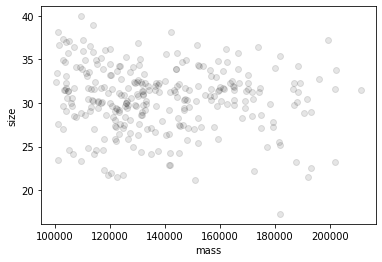

In [51]:
plt.figure()
tp.mass_size(t2.groupby('particle').mean())

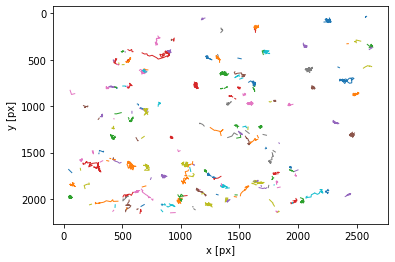

In [57]:
plt.figure()
tp.plot_traj(t1);

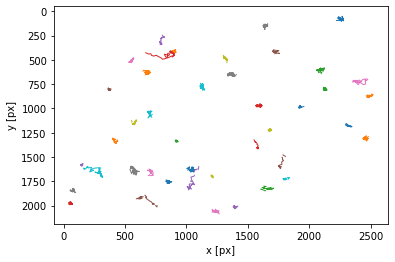

In [62]:
plt.figure()
tp.plot_traj(t11);

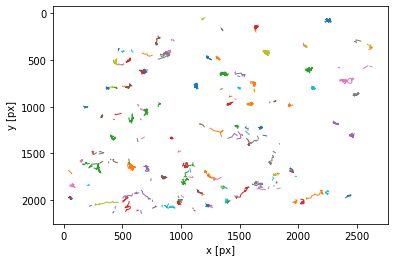

In [61]:
plt.figure()
tp.plot_traj(t2);

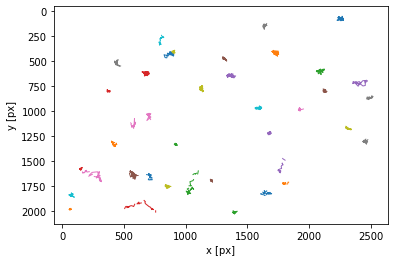

In [63]:
plt.figure()
tp.plot_traj(t22);

#  Remove overall drift
Compute the overall drifting motion, which we will subtract away
adopting the reference frame of the particles' average position

In [65]:
d1 = tp.compute_drift(t1)
d11 = tp.compute_drift(t11)

d2 = tp.compute_drift(t2)
d22 = tp.compute_drift(t22)

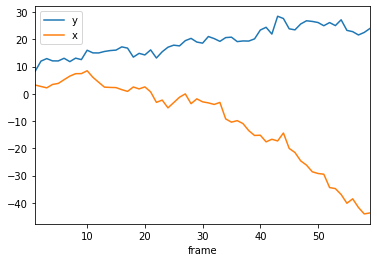

In [66]:
d1.plot()
plt.show()

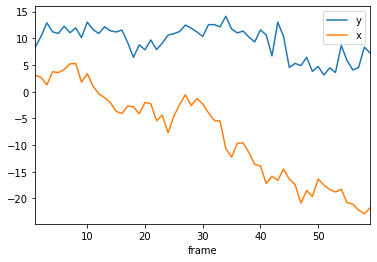

In [67]:
d11.plot()
plt.show()

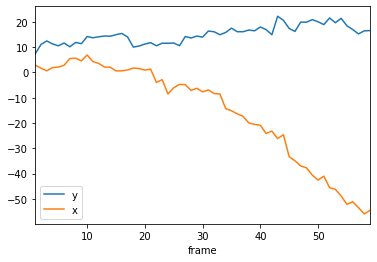

In [68]:
d2.plot()
plt.show()

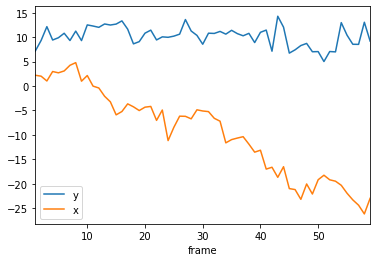

In [69]:
d22.plot()
plt.show()

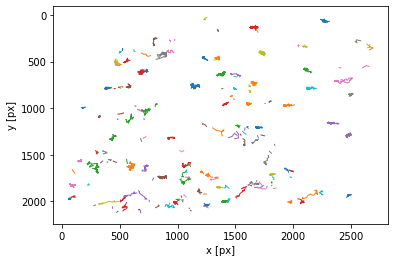

In [73]:
tm = tp.subtract_drift(t2.copy(), d2)
ax = tp.plot_traj(tm)
plt.show()

# Analyze trajectories
Trackpy includes several functions to help with some common analyses for particle trajectories. (See the "Static Analysis" and "Motion Analysis" sections of the API reference.)

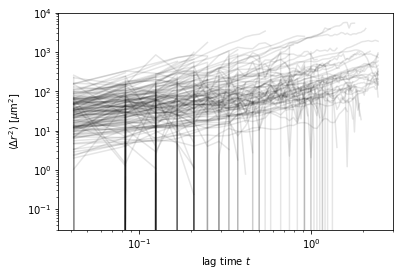

In [74]:
# Mean Squared Displacement of Individal Probes

# Compute the mean squared displacement (MSD)
# of each particle using the imsd function, and plot MSD vs. lag time.

im = tp.imsd(tm, 100/285., 24)  # microns per pixel = 100/285., frames per second = 24

fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]', xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')